In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from tensorflow.keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from tensorflow.keras import applications 
 
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math  
import datetime
import time
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import os
import tensorflow as tf


In [ ]:
img_width, img_height = 224, 224  

train_data_dir = '/content/gdrive/My Drive/Soil Data Set New/train/'  
test_data_dir = '/content/gdrive/My Drive/Soil Data Set New/test/'



top_model_weights_path = 'bottleneck_fc_model_vgg19.h5' 


#TUNING SEBAGIAN DISINI
batch_size = 8
lr=1e-4
opt='rmsprop'
epochs = 100 
  

vgg19 = applications.VGG19(include_top=False, weights='imagenet') 
vgg19.summary() #Arsitekturnya Wan

datagen = ImageDataGenerator(rescale=1. / 255)  
train_datagen = ImageDataGenerator(#rescale=1. / 255) 
        rescale=1. / 255,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)    
#


#

#Pre train Training
start = datetime.datetime.now()
   
train_generator = train_datagen.flow_from_directory(  
      train_data_dir,  
      target_size=(img_width, img_height),  
      batch_size=batch_size,  
      class_mode=None,  
      shuffle=False)  
   
nb_train_samples = len(train_generator.filenames)  
num_classes = len(train_generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg19.predict_generator(train_generator, predict_size_train)  
   
np.save('/content/gdrive/My Drive/bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)




#Pre train Testing
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
      test_data_dir,  
      target_size=(img_width, img_height),  
      batch_size=batch_size,  
      class_mode=None,  
      shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg19.predict_generator(  
      generator, predict_size_test)  
   
np.save('/content/gdrive/My Drive/bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)



Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Time:  0:17:29.615094
Found 350 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Time:  0:03:23.432685


In [ ]:
from sklearn.metrics import confusion_matrix
#TRAINING
#vgg19 = applications.vgg19(include_top=False, weights='imagenet') 
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("confusion matrix yang dinormalisasi \n\n\n")
    else:
        print('Confusion matrix tanpa normalisasi \n\n\n')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


img_width, img_height = 224, 224  
top_model_weights_path = 'bottleneck_fc_model.h5' 

datagen = ImageDataGenerator(rescale=1. / 255) 
 
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
train_data = np.load('/content/gdrive/My Drive/bottleneck_features_train.npy')  
   
train_labels = generator_top.classes  
   
train_labels = to_categorical(train_labels, num_classes=num_classes) 

#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('/content/gdrive/My Drive/bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

#Lanjut training 
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
#model.add(Dense(100, activation=LeakyReLU(alpha=0.3)))
model.add(Dense(100))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))  
#model.add(Dense(50, activation=LeakyReLU(alpha=0.3)))
model.add(Dense(50))
model.add(LeakyReLU(alpha=0.3))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=lr),
              metrics=['acc'])  


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('/content/gdrive/My Drive/models/vgg19/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# history = model.fit(train_data, train_labels,  
#       epochs=20,
#       batch_size=batch_size,  
#       validation_data=(test_data, test_labels))


history = model.fit(train_data, train_labels,  
      epochs=100,
      batch_size=batch_size,  
      validation_data=(test_data, test_labels),
      verbose=0,
      callbacks=[es, mc])    

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 test_data, test_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

#Model summary
model.summary()

#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))



Found 2264 images belonging to 4 classes.
Found 350 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)



Epoch 1: val_acc improved from -inf to 0.86571, saving model to /content/gdrive/My Drive/models/vgg19/best_model.h5

Epoch 2: val_acc improved from 0.86571 to 0.87714, saving model to /content/gdrive/My Drive/models/vgg19/best_model.h5

Epoch 3: val_acc improved from 0.87714 to 0.89429, saving model to /content/gdrive/My Drive/models/vgg19/best_model.h5

Epoch 4: val_acc did not improve from 0.89429

Epoch 5: val_acc improved from 0.89429 to 0.91429, saving model to /content/gdrive/My Drive/models/vgg19/best_model.h5

Epoch 6: val_acc did not improve from 0.91429

Epoch 7: val_acc did not improve from 0.91429

Epoch 8: val_acc did not improve from 0.91429

Epoch 9: val_acc did not improve from 0.91429

Epoch 10: val_acc did not improve from 0.91429
Epoch 10: early stopping


KeyboardInterrupt: ignored

In [ ]:
# Create predictions for test images

predictions3 = model.predict(test_data)
predictions3 = np.argmax(predictions3,axis=1)
predictions3[:15]

array([0, 0, 2, 0, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2])

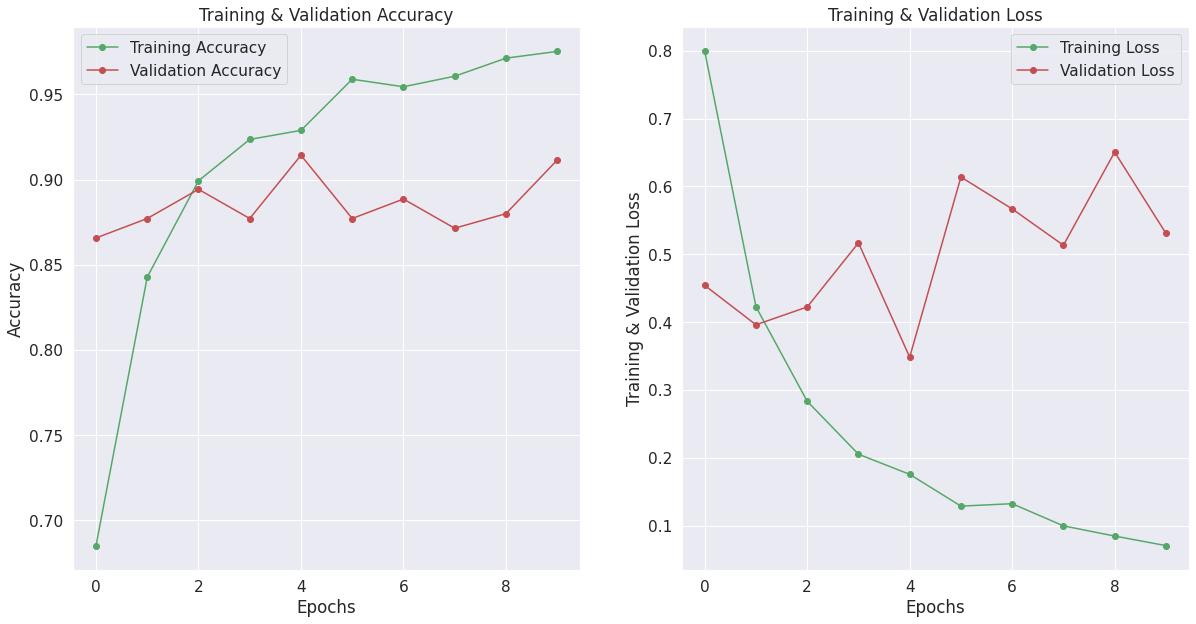

In [ ]:
import matplotlib.pyplot as plt 
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(30)]
    fig , ax = plt.subplots(1,2)
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))


    fig.set_size_inches(20,10)
    ax[0].plot(epochs , acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()
plot_accuracy_loss_chart(history)

In [ ]:
import numpy as np
rounded_labels=np.argmax(test_labels, axis=1)
rounded_labels[1]
# 2

rounded_predictions = model.predict(test_data, batch_size=128, verbose=0)
rounded_predictions[1]

array([0.7033613 , 0.01078226, 0.2800258 , 0.00583064], dtype=float32)

In [ ]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)

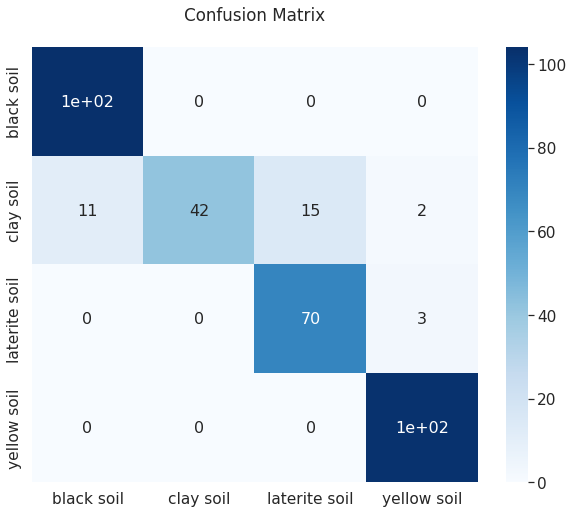

Classification Report

               precision    recall  f1-score   support

   black soil       0.90      1.00      0.95       104
    clay soil       1.00      0.60      0.75        70
laterite soil       0.82      0.96      0.89        73
  yellow soil       0.95      1.00      0.98       103

     accuracy                           0.91       350
    macro avg       0.92      0.89      0.89       350
 weighted avg       0.92      0.91      0.90       350



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
Y_pred = model.predict(test_data, int(968/44))
y_pred = np.argmax(Y_pred, axis = 1)

cm = confusion_matrix(generator_top.classes, y_pred)
df_cm = pd.DataFrame(cm, list(generator_top.class_indices.keys()), list(generator_top.class_indices.keys()))

fig, ax = plt.subplots(figsize = (10,8))
sns.set(font_scale = 1.4) # for label size
sns.heatmap(df_cm, annot = True, annot_kws = {"size": 16}, cmap = plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent = False, bbox_inches = 'tight', dpi = 400)
plt.show()

print('Classification Report\n')
target_names = list(generator.class_indices.keys())
print(classification_report(generator.classes, y_pred, target_names = target_names))